**ANALISIS SENTIMEN & TOPIK ULASAN POSPAY**

# Instalansi Library
Penjelasan
- google-play-scraper → mengambil ulasan aplikasi dari Google Play Store
- pandas → mengelola data
- sastrawi → stemming Bahasa Indonesia
- transformers → analisis sentimen berbasis AI (IndoBERT)
- BERTopic → pemodelan topik otomatis

In [13]:
# Instalasi library yang dibutuhkan
!pip install google-play-scraper
!pip install pandas tqdm sastrawi
!pip install transformers torch
!pip install sentence-transformers bertopic
!pip install umap-learn hdbscan

# Import Library

In [14]:
# Import library
import pandas as pd
import re
from tqdm import tqdm

from google_play_scraper import reviews_all, Sort
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Scraping Ulasan Pospay dari Google Play
Data diambil langsung dari Google Play Store

Data penting:
- content → teks ulasan
- score → rating (1–5)
- at → tanggal ulasan

In [15]:
# Mengambil ulasan aplikasi Pospay
app_package = "com.posindonesia.pospaymobilenew"

reviews = reviews_all(
    app_package,
    lang='id',        # Bahasa Indonesia
    country='id',     # Wilayah Indonesia
    sort=Sort.NEWEST  # Urutkan dari ulasan terbaru
)

# Konversi ke DataFrame
df = pd.DataFrame(reviews)

# Simpan data mentah
df.to_csv("pospay_reviews_raw.csv", index=False)

print("Jumlah ulasan:", len(df))
df.head()

Jumlah ulasan: 118


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,6146c720-5394-43fe-953f-25739c3f4821,AhmadFauzi R,https://play-lh.googleusercontent.com/a/ACg8oc...,"belum bisaa untuk transfer via semua Bank, dan...",2,0,1.5.1,2025-12-16 05:22:44,None,None,1.5.1
1,5c81128b-c77a-4530-8562-ad9fec704927,Muhammad Heriannoor,https://play-lh.googleusercontent.com/a-/ALV-U...,untuk verifikasi wajah sdah berhasil.. dan apl...,1,1,1.5.0,2025-12-10 12:04:19,None,None,1.5.0
2,8a8ac2a3-4599-4a09-99c6-a9a879e17a92,Aurelius Kamarea,https://play-lh.googleusercontent.com/a-/ALV-U...,KENAPA TIDAK BISA MENYIMPAN DOKUMEN,5,0,1.5.0,2025-12-01 04:02:15,None,None,1.5.0
3,2ecd0b83-f5e0-471e-8a66-857d6a0302fc,surya adi,https://play-lh.googleusercontent.com/a/ACg8oc...,Sangat mudah digunakan ... bisa bayar beli keb...,5,0,1.4.0,2025-10-21 14:46:56,None,None,1.4.0
4,13462770-95da-44f7-90f5-5effaccd4098,Rustam Renaldy,https://play-lh.googleusercontent.com/a-/ALV-U...,Transaksi belasan juta setiap bulan gak dpt po...,1,5,1.4.0,2025-10-20 02:00:52,None,None,1.4.0


# Preprocessing Teks
Tahap preprocessing bertujuan untuk:
- Menghilangkan noise (URL, simbol, angka)
- Menyamakan bentuk kata (stemming)
- Meningkatkan akurasi analisis sentimen & topik

In [16]:
# Preprocessing teks ulasan
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)        # Hapus URL
    text = re.sub(r"[^a-zA-Z\s]", " ", text)   # Hapus angka & simbol
    text = re.sub(r"\s+", " ", text).strip()   # Hapus spasi berlebih
    text = stemmer.stem(text)                  # Stemming
    return text

tqdm.pandas()
df['clean_review'] = df['content'].progress_apply(clean_text)

df[['content', 'clean_review']].head()

100%|██████████| 118/118 [01:27<00:00,  1.35it/s]


,content,clean_review
0,"belum bisaa untuk transfer via semua Bank, dan...",belum bisaa untuk transfer via semua bank dan ...
1,untuk verifikasi wajah sdah berhasil.. dan apl...,untuk verifikasi wajah sdah hasil dan aplikasi...
2,KENAPA TIDAK BISA MENYIMPAN DOKUMEN,kenapa tidak bisa simpan dokumen
3,Sangat mudah digunakan ... bisa bayar beli keb...,sangat mudah guna bisa bayar beli butuh hari
4,Transaksi belasan juta setiap bulan gak dpt po...,transaksi bas juta tiap bulan gak dpt poin sam...


# Analisis Sentimen (Transformer / IndoBERT)
Model RoBERTa Bahasa Indonesia

Output sentimen:
- positive
- neutral
- negative

Cocok untuk analisis opini pengguna aplikasi

In [17]:
# Analisis Sentimen
from transformers import pipeline

sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="w11wo/indonesian-roberta-base-sentiment-classifier"
)

# Prediksi sentimen
sentiment_result = sentiment_pipeline(df['clean_review'].tolist())

df['sentiment'] = [res['label'] for res in sentiment_result]
df['sentiment_score'] = [res['score'] for res in sentiment_result]

df[['content', 'sentiment', 'sentiment_score']].head()

Device set to use cpu


,content,sentiment,sentiment_score
0,"belum bisaa untuk transfer via semua Bank, dan...",neutral,0.975016
1,untuk verifikasi wajah sdah berhasil.. dan apl...,negative,0.535123
2,KENAPA TIDAK BISA MENYIMPAN DOKUMEN,negative,0.870907
3,Sangat mudah digunakan ... bisa bayar beli keb...,positive,0.981777
4,Transaksi belasan juta setiap bulan gak dpt po...,negative,0.995330


# Cross-check sentimen dengan rating

In [18]:
# Cross-check sentimen dengan rating
pd.crosstab(df['score'], df['sentiment'])

sentiment,negative,neutral,positive
score,,,
1,59,13,1
2,1,1,0
3,5,2,0
4,2,2,1
5,7,3,21


### Interpretasi Validasi Sentimen dan Rating

Hasil validasi menunjukkan bahwa 59 dari 73 ulasan dengan
rating 1 (80,8%) diklasifikasikan sebagai sentimen negatif.
Pada sisi lain, dari 31 ulasan dengan rating 5, masih terdapat
7 ulasan (22,6%) yang diklasifikasikan sebagai negatif.
Hal ini mengindikasikan bahwa pengguna tetap menyampaikan
keluhan meskipun memberikan rating tinggi.


# Visualisasi Distribusi Sentimen
Visualisasi ini menunjukkan tingkat kepuasan pengguna terhadap aplikasi Pospay.

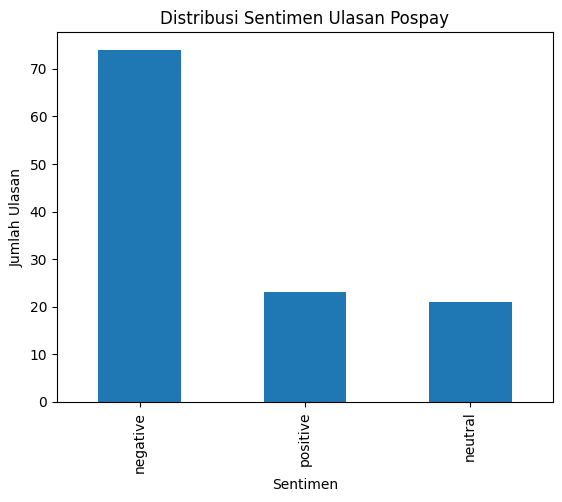

In [19]:
# Visualisasi distribusi sentimen
import matplotlib.pyplot as plt

df['sentiment'].value_counts().plot(kind='bar')
plt.title("Distribusi Sentimen Ulasan Pospay")
plt.xlabel("Sentimen")
plt.ylabel("Jumlah Ulasan")
plt.show()

### Interpretasi Distribusi Sentimen

Hasil analisis menunjukkan bahwa sentimen negatif mendominasi
ulasan pengguna. Namun, hasil ini tidak secara langsung
menunjukkan bahwa pengguna sepenuhnya tidak puas.
Berdasarkan pemeriksaan data, ditemukan bahwa sebagian ulasan
dengan rating tinggi tetap mengandung keluhan terhadap fitur
atau performa aplikasi, sehingga diklasifikasikan sebagai
sentimen negatif oleh model.

# Topic Modeling (BERTopic)
Penjelasan

- BERTopic mengelompokkan ulasan berdasarkan kesamaan makna
- Tidak perlu menentukan jumlah topik secara manual
- Sangat cocok untuk data teks besar

In [20]:
# Topic Modeling dengan BERTopic
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic

embedding_model = SentenceTransformer(
    "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"
)

topic_model = BERTopic(
    embedding_model=embedding_model,
    language="indonesian"
)

topics, probs = topic_model.fit_transform(df['clean_review'])

df['topic'] = topics
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,clean_review,sentiment,sentiment_score,topic
0,6146c720-5394-43fe-953f-25739c3f4821,AhmadFauzi R,https://play-lh.googleusercontent.com/a/ACg8oc...,"belum bisaa untuk transfer via semua Bank, dan...",2,0,1.5.1,2025-12-16 05:22:44,None,None,1.5.1,belum bisaa untuk transfer via semua bank dan ...,neutral,0.975016,-1
1,5c81128b-c77a-4530-8562-ad9fec704927,Muhammad Heriannoor,https://play-lh.googleusercontent.com/a-/ALV-U...,untuk verifikasi wajah sdah berhasil.. dan apl...,1,1,1.5.0,2025-12-10 12:04:19,None,None,1.5.0,untuk verifikasi wajah sdah hasil dan aplikasi...,negative,0.535123,0
2,8a8ac2a3-4599-4a09-99c6-a9a879e17a92,Aurelius Kamarea,https://play-lh.googleusercontent.com/a-/ALV-U...,KENAPA TIDAK BISA MENYIMPAN DOKUMEN,5,0,1.5.0,2025-12-01 04:02:15,None,None,1.5.0,kenapa tidak bisa simpan dokumen,negative,0.870907,0
3,2ecd0b83-f5e0-471e-8a66-857d6a0302fc,surya adi,https://play-lh.googleusercontent.com/a/ACg8oc...,Sangat mudah digunakan ... bisa bayar beli keb...,5,0,1.4.0,2025-10-21 14:46:56,None,None,1.4.0,sangat mudah guna bisa bayar beli butuh hari,positive,0.981777,2
4,13462770-95da-44f7-90f5-5effaccd4098,Rustam Renaldy,https://play-lh.googleusercontent.com/a-/ALV-U...,Transaksi belasan juta setiap bulan gak dpt po...,1,5,1.4.0,2025-10-20 02:00:52,None,None,1.4.0,transaksi bas juta tiap bulan gak dpt poin sam...,negative,0.995330,2


### Interpretasi Hasil Topic Modeling

Pemodelan topik menghasilkan beberapa topik utama yang
merepresentasikan isu pengguna. Topik "Kendala Verifikasi
dan Transaksi" serta "Masalah Login dan OTP" merupakan topik
yang paling sering muncul pada sentimen negatif. Sementara itu,
topik "Ulasan Umum atau Pujian Singkat" didominasi oleh sentimen
positif dan berisi penilaian umum terhadap aplikasi.


# Melihat Topik Utama
Tabel ini berisi:
- Nomor topik
- Jumlah ulasan
- Kata kunci utama tiap topik

In [21]:
# Informasi topik
topic_info = topic_model.get_topic_info()
topic_info

,Topic,Count,Name,Representation,Representative_Docs
0,-1,15,-1_aplikasi_sampai_transfer_riwayat,"[aplikasi, sampai, transfer, riwayat, untuk, d...",[hai min untuk cek riwayat transfer yang masuk...
1,0,45,0_verifikasi_email_tidak_susah,"[verifikasi, email, tidak, susah, kode, masuk,...","[email verifikasi otp tidak masuk pada, susah ..."
2,1,31,1_keren_buka_mantap_bagus,"[keren, buka, mantap, bagus, lebih, gg, jelek,...",[edun mau buka aja loading nya jam jam bikin m...
3,2,27,2_aplikasi_di_pospay_ga,"[aplikasi, di, pospay, ga, dan, yg, yang, sist...",[aja dulu min mau nanya benar kendala apa yang...


# Contoh Ulasan per Topik
Digunakan untuk interpretasi manual agar topik mudah dipahami.

In [22]:
# Contoh ulasan dari satu topik
df[df['topic'] == 0][['content', 'sentiment']].head(5)

,content,sentiment
1,untuk verifikasi wajah sdah berhasil.. dan apl...,negative
2,KENAPA TIDAK BISA MENYIMPAN DOKUMEN,negative
6,"bisa bisa nya APK nya ada malware nya, tolong ...",negative
15,belum ada Qris cpm untuk bayar belanja di alfa...,neutral
17,NIK NAMA IBU KANDUNG UDAH BENER TGL LAHIR JUGA...,negative


# Simpan Hasil Akhir


In [23]:
# Simpan hasil analisis
df.to_csv("pospay_sentiment_topic_result.csv", index=False)
topic_info.to_csv("pospay_topic_info.csv", index=False)

## Kesimpulan

Berdasarkan analisis sentimen dan pemodelan topik, dapat
disimpulkan bahwa pengguna Pospay secara umum memberikan
respon beragam. Meskipun banyak ulasan bernada negatif,
keluhan utama terfokus pada aspek teknis seperti verifikasi,
login, dan performa aplikasi, bukan pada fungsi utama layanan.


## Insight Utama

- Analisis sentimen terhadap 118 ulasan menunjukkan bahwa sentimen
  negatif mendominasi, yang menandakan banyaknya keluhan pengguna
  terhadap aspek teknis aplikasi.

- Hasil validasi dengan rating menunjukkan bahwa meskipun pengguna
  memberikan rating tinggi, mereka tetap menyampaikan kritik
  terhadap fitur tertentu, sehingga analisis berbasis teks mampu
  menangkap keluhan secara lebih detail dibandingkan rating numerik.

- Pemodelan topik mengungkapkan bahwa keluhan utama pengguna
  berfokus pada kendala verifikasi, login, dan transaksi, sementara
  ulasan positif umumnya bersifat umum dan singkat.
